# Compare ATL10 freeboard product with optical images

## 	&#x2B50; Objectives
- Query optical images in Google Earth Engine and download images overlapped with ICESat-2 track 
- Compare sea ice features from optical images and ICESat-2 ATL10 product

## &#x2705; Computing environment

We'll be using the following Python libraries in this notebook:

In [4]:
%matplotlib widget
import glob, os
import ee
import geemap
import requests
import numpy as np

from datetime import datetime
from datetime import timedelta
# import rasterio as rio
# from rasterio import plot
# from rasterio import warp
import h5py
import pandas as pd

import os

# import icepyx as ipx

import warnings
warnings.filterwarnings('ignore')

import geopandas
import rasterio
import matplotlib.pyplot as plt
# from shapely.geometry import Point
from rasterio.plot import show


    
The import below is a class that I wrote myself. It helps us read and store data from the OpenAltimetry API.  
If you are interested in how this works, you can find the code in `utils/oa.py`.

## Google Earth Engine Authentication and Initialization
GEE requires you to authenticate your access, so if `ee.Initialize()` does not work you first need to run `ee.Authenticate()`. This gives you a link at which you can use your google account that is associated with GEE to get an authorization code. Copy the authorization code into the input field and hit *enter* to complete authentication. 

In [5]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

Enter verification code:  4/1AZEOvhUw6vAFcwgunj1JxK-_OQTfqEyGNW9hrkUX9RrBc992dKXWbk0i-2Y



Successfully saved authorization token.


## Download ATL10 files using icepyx

####  Read the list of ATL10 and Sentinel-2 pairs.

####  NOTE: Once you download all the ATL10 files in the filelist, you can skip the cell below.

## Visualize ATL10 data and overlapped Sentinel-2 RGB image (new version)

In [715]:
filename = "processed_ATL10-02_20191113181045_07310501_005_02.h5"

with h5py.File(filename, 'r') as f:
    beam = 'gt3r'
    track = pd.DataFrame(data={'lat': f[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:],
                              'lon': f[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:],
                             'freeboard': f[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:],
                              'type': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_type'][:]
                              })

# Map = geemap.Map(center=(is2_l.lat.mean(), is2_l.lon.mean()), zoom=7)

track_coord = list(zip([x for x in track.lon[::100]], [x for x in track.lat[::100]])) 
feature_track = ee.FeatureCollection(ee.Geometry.LineString(coords=track_coord, proj='EPSG:4326', geodesic=True)) 
# spatial_extent = [-170, -78, -160, -74]

roi = feature_track.geometry() #ee.Geometry.Rectangle([-60, -68, -40, -62]) #


In [716]:
time_atl = datetime.strptime(filename[19:33], "%Y%m%d%H%M%S")

In [717]:
t1 = datetime.strptime(filename[19:27], "%Y%m%d").strftime("%Y-%m-%d")
t2 = (datetime.strptime(t1, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")

S2 = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(roi)\
.filterDate(t1, t2)\
.filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT', 20))

In [779]:
img.getInfo()

AttributeError: 'DatasetReader' object has no attribute 'getInfo'

In [780]:
img = ee.Image(ids[i]).select('B4')
img.getInfo()

ConnectTimeout: HTTPSConnectionPool(host='accounts.google.com', port=443): Max retries exceeded with url: /o/oauth2/token (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001613B1E7790>, 'Connection to accounts.google.com timed out. (connect timeout=None)'))

In [719]:
num = S2.size().getInfo()
filtered_list = S2.toList(num)
print(num)

4


In [720]:
ids = [filtered_list.getInfo()[i]['id'] for i in range(0, num)] 
ids

['COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNA',
 'COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNV',
 'COPERNICUS/S2_SR/20191113T183459_20191113T183501_T03CVQ',
 'COPERNICUS/S2_SR/20191113T183459_20191113T183501_T03CVR']

In [721]:
time_diff = 3600*3 # Time difference < 2 hours

for i in range(0, num):
    time_start = filtered_list.getInfo()[i]['properties']['system:time_start']
    time_s2 = datetime(1970, 1, 1) + timedelta(seconds = time_start/1000)   
    
    img_name = os.path.basename(ids[i])

    # Time difference between IS2 and S2 < defined time_diff
    if abs(time_atl-time_s2).seconds <= time_diff:
        img = ee.Image(ids[i]).select('B4')
        geemap.download_ee_image(img, f"S2_{img_name}.tif", scale=50)
    else:
        print(f"SKIP {img_name}: Time difference > {time_diff/3600} hours with ICESat-2 track")

S2_20191113T183459_20191113T183501_T02CNA.tif: |                      | 0.00/2.27M (raw) [  0.0%] in 00:00 (et…

S2_20191113T183459_20191113T183501_T02CNV.tif: |                      | 0.00/9.68M (raw) [  0.0%] in 00:00 (et…

S2_20191113T183459_20191113T183501_T03CVQ.tif: |                      | 0.00/9.73M (raw) [  0.0%] in 00:00 (et…

S2_20191113T183459_20191113T183501_T03CVR.tif: |                      | 0.00/9.66M (raw) [  0.0%] in 00:00 (et…

In [105]:
# img = ee.Image(S2_id)
Map = geemap.Map()
Map.centerObject(img, zoom = 7)
Map.addLayer(img, {'min': 0, 'max': 10000}, img_name)

Map

Map(center=[-64.51615362617625, -51.94045496865766], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Another way to download Sentinel2 image

downloadURL = img.getDownloadUrl({'name': img_name,
                                  'crs': 'EPSG:32721',
                                  'scale': 50,
                                  'region': img.geometry(),
                                  'filePerBand': True,
                                  'format': "GEO_TIFF"})

print("Link to download: ", downloadURL)

In [328]:
img.crs

CRS.from_epsg(32721)

## Comparison between ICESat-2 and Sentinel-2

In [5]:
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show

import datetime as dt
import pandas as pd

import numpy as np
import glob, os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Segment load

In [768]:
# Read downloaded Sentinel-2 image
img_name = "S2_20191113T183459_20191113T183501_T03CVR.tif"

In [769]:
img = rasterio.open(img_name)
img.transform

Affine(50.0, 0.0, 399900.0,
       0.0, -50.0, 1600050.0)

In [770]:
img.crs

CRS.from_epsg(32703)

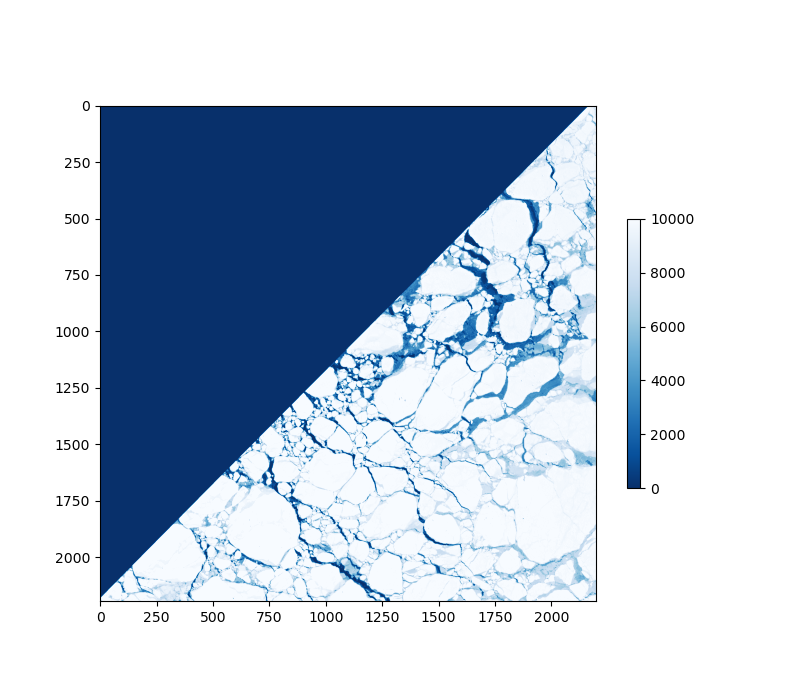

In [771]:
array = img.read(1)
array[array < 0] = 0
plt.figure(figsize = (8, 7))
plt.imshow(array, cmap = "Blues_r", vmin = 0, vmax = 10000)
plt.colorbar(shrink = 0.5)

In [772]:
height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)
print('lons shape', lons.shape)

lons shape (1104, 1099)


## Raw image load

## Read ATL10 files

In [773]:
track

,lat,lon,freeboard,type
0,-73.976213,-165.954964,3.402823e+38,1
1,-73.976335,-165.955030,3.402823e+38,1
2,-73.976529,-165.955138,3.402823e+38,1
3,-73.976916,-165.955354,3.402823e+38,1
4,-73.977494,-165.955673,3.402823e+38,1
...,...,...,...,...
43244,-76.970879,-167.870298,1.106582e+00,1
43245,-76.970926,-167.870337,1.143658e+00,1
43246,-76.970972,-167.870374,1.154237e+00,1
43247,-76.971013,-167.870407,1.191318e+00,1


In [774]:
gdf = geopandas.GeoDataFrame(track, geometry=geopandas.points_from_xy(track.lon, track.lat))
gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf = gdf.to_crs(img.crs)

In [775]:
gdf

,lat,lon,freeboard,type,geometry
0,-73.976213,-165.954964,3.402823e+38,1,POINT (470577.403 1790379.945)
1,-73.976335,-165.955030,3.402823e+38,1,POINT (470575.582 1790366.387)
2,-73.976529,-165.955138,3.402823e+38,1,POINT (470572.616 1790344.654)
3,-73.976916,-165.955354,3.402823e+38,1,POINT (470566.649 1790301.392)
4,-73.977494,-165.955673,3.402823e+38,1,POINT (470557.874 1790236.753)
...,...,...,...,...,...
43244,-76.970879,-167.870298,1.106582e+00,1,POINT (427791.472 1454713.950)
43245,-76.970926,-167.870337,1.143658e+00,1,POINT (427790.764 1454708.669)
43246,-76.970972,-167.870374,1.154237e+00,1,POINT (427790.073 1454703.481)
43247,-76.971013,-167.870407,1.191318e+00,1,POINT (427789.466 1454698.895)


In [776]:
gdf['x'] = gdf.geometry.apply(lambda x: x.x)
gdf['y'] = gdf.geometry.apply(lambda x: x.y)

x_min = xs.min()
x_max = xs.max()
y_min = ys.min()
y_max = ys.max()

gdf = gdf[(gdf["x"]>=x_min) & (gdf["x"]<=x_max) & (gdf["y"]>=y_min) & (gdf["y"]<=y_max)].reset_index(drop=True)

idx = img.index(gdf["x"], gdf["y"])
gdf["pix_x"] = idx[1]
gdf["pix_y"] = idx[0]

In [777]:
gdf

,lat,lon,freeboard,type,geometry,x,y,pix_x,pix_y
0,-75.676462,-166.955485,0.077530,1,POINT (446006.483 1600022.773),446006.482997,1.600023e+06,922,0
1,-75.676518,-166.955523,0.095200,1,POINT (446005.667 1600016.418),446005.667052,1.600016e+06,922,0
2,-75.676580,-166.955563,0.106182,1,POINT (446004.786 1600009.551),446004.785836,1.600010e+06,922,0
3,-75.676633,-166.955597,0.118669,1,POINT (446004.021 1600003.594),446004.021193,1.600004e+06,922,0
4,-75.676697,-166.955640,0.130420,1,POINT (446003.096 1599996.380),446003.095600,1.599996e+06,922,1
...,...,...,...,...,...,...,...,...,...
18882,-76.654593,-167.632068,0.183230,1,POINT (432202.481 1490255.502),432202.480862,1.490256e+06,646,2195
18883,-76.654651,-167.632110,0.161595,1,POINT (432201.692 1490249.082),432201.692417,1.490249e+06,646,2196
18884,-76.654706,-167.632150,0.164691,1,POINT (432200.925 1490242.820),432200.924633,1.490243e+06,646,2196
18885,-76.654767,-167.632195,0.164645,1,POINT (432200.090 1490236.006),432200.089770,1.490236e+06,646,2196


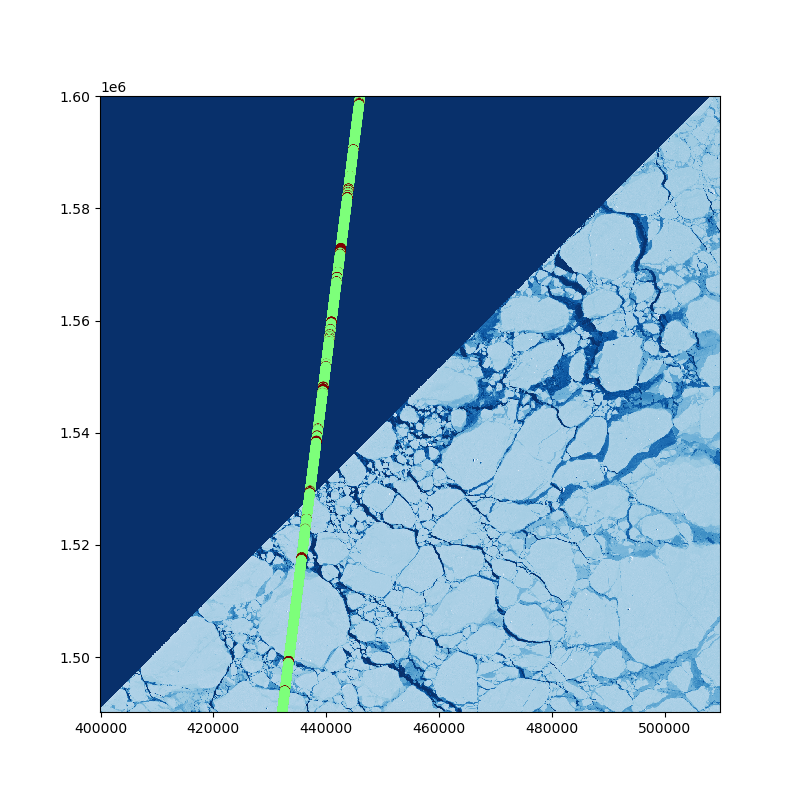

In [778]:
plt.figure(figsize = (8,8))
plt.pcolormesh(xs, ys, array, cmap = "Blues_r")
plt.scatter(gdf['x'], gdf['y'], c = gdf['type'], vmin = 0, vmax = 2, cmap = "jet")

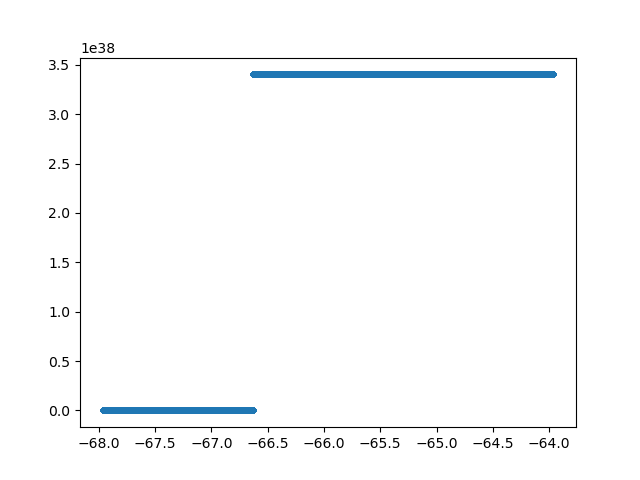

In [398]:
plt.figure()
plt.plot(track.lat, track.freeboard, '.')

In [17]:
# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2

from readers.get_ATL10 import get_ATL10data
from readers.getATL07 import get_ATL07

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)
print(xs.shape)

(3053, 2548)


In [153]:
def calculate_floesize(array, segment, cellsize = 50*50):
    if segment != 0:
        floesize = len(np.where(array == segment)[0]) * cellsize
    else:
        floesize = 0
    return floesize     
    

list10 = pd.read_csv("F:\\IS2_floes\\Overlapped_ATL10_S2_{0}_2018-09-01_2022-03-31_filtered.csv".format(region))
atlfile = list10[list10['S1_id'] == "COPERNICUS/S2_SR/"+imgfile]['IS2_file'].values[0]

beam = 0
df0 = get_ATL10data("F:\\IS2_floes\\ATL10\\" + region + "\\" + atlfile, 1000, None)[beam]
df0['x_atc'] = df0['x']
df0.drop(['x'], axis = 1)

gdf = geopandas.GeoDataFrame(df0, geometry=geopandas.points_from_xy(df0.lon, df0.lat))
gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf = gdf.to_crs('epsg:3976')

gdf['x'] = gdf.geometry.apply(lambda x: x.x)
gdf['y'] = gdf.geometry.apply(lambda x: x.y)

df = pd.DataFrame(gdf)    

x_min = xs.min()
x_max = xs.max()
y_min = ys.min()
y_max = ys.max()

df = df[(df["x"]>=x_min) & (df["x"]<=x_max) & (df["y"]>=y_min) & (df["y"]<=y_max)]

idx = img.index(df["x"], df["y"])
df["pix_x"] = idx[1]
df["pix_y"] = idx[0]
df["S2_value"] = raw[idx[0], idx[1]]
df["segment"] = array[idx[0], idx[1]]

cellsize = 50*50
for k in np.unique(df["segment"]):
    if k > 0:
        floesize = len(np.where(array == k)[0]) * cellsize
    else:
        floesize = 0
    df.loc[df["segment"]==k, "floesize"] = floesize
    
    if k % 1000 == 0:
        print(k)

df = df.reset_index(drop = True)
print("FINISH!!")

FINISH!!


In [154]:
df

,beam,lon,lat,x,delta_time,seg_id,height,freeboard,mss,h_ref,...,minute,second,x_atc,geometry,y,pix_x,pix_y,S2_value,segment,floesize
0,gt1l,-38.182929,-75.044710,-1.006979e+06,1.267856e+08,49437,-0.067652,0.122374,-2.093501,-0.190026,...,13,41,3.176689e+07,POINT (-1006978.529 1280426.275),1.280426e+06,1459,3052,0,NaN,NaN
1,gt1l,-38.182959,-75.044659,-1.006983e+06,1.267856e+08,49438,-0.074755,0.115270,-2.093297,-0.190026,...,13,41,3.176689e+07,POINT (-1006982.647 1280430.132),1.280430e+06,1459,3052,0,NaN,NaN
2,gt1l,-38.182986,-75.044614,-1.006986e+06,1.267856e+08,49439,-0.044095,0.145931,-2.093231,-0.190026,...,13,41,3.176690e+07,POINT (-1006986.333 1280433.583),1.280434e+06,1459,3052,0,NaN,NaN
3,gt1l,-38.183008,-75.044576,-1.006989e+06,1.267856e+08,49440,-0.099515,0.090510,-2.093231,-0.190026,...,13,41,3.176690e+07,POINT (-1006989.402 1280436.455),1.280436e+06,1459,3052,0,NaN,NaN
4,gt1l,-38.183032,-75.044537,-1.006993e+06,1.267856e+08,49441,-0.137842,0.052184,-2.093062,-0.190026,...,13,41,3.176691e+07,POINT (-1006992.613 1280439.460),1.280439e+06,1459,3052,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15861,gt1l,-38.682787,-74.147776,-1.079905e+06,1.267856e+08,65551,0.364138,0.522363,-3.325078,-0.158225,...,13,55,3.186810e+07,POINT (-1079904.670 1348771.561),1.348772e+06,0,1685,0,NaN,NaN
15862,gt1l,-38.682812,-74.147730,-1.079908e+06,1.267856e+08,65552,0.409759,0.567985,-3.325586,-0.158225,...,13,55,3.186810e+07,POINT (-1079908.448 1348775.071),1.348775e+06,0,1685,0,NaN,NaN
15863,gt1l,-38.682847,-74.147666,-1.079914e+06,1.267856e+08,65553,0.512598,0.670824,-3.325586,-0.158225,...,13,55,3.186811e+07,POINT (-1079913.693 1348779.940),1.348780e+06,0,1685,0,NaN,NaN
15864,gt1l,-38.682873,-74.147618,-1.079918e+06,1.267856e+08,65554,0.419430,0.577655,-3.326068,-0.158225,...,13,55,3.186812e+07,POINT (-1079917.591 1348783.554),1.348784e+06,0,1685,0,NaN,NaN


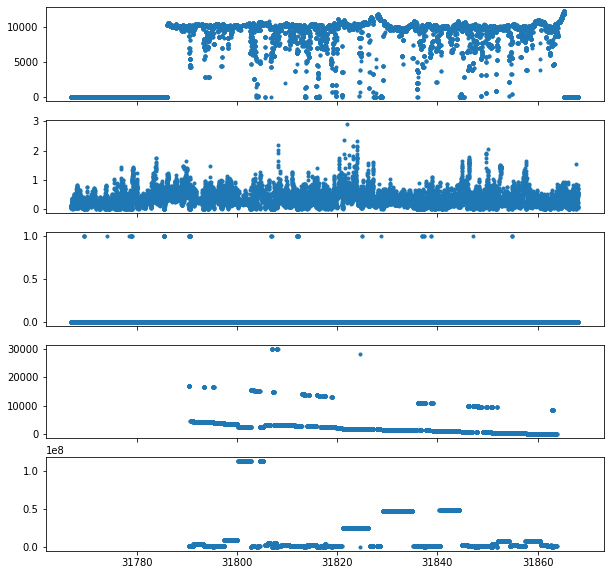

In [155]:
fields = ["S2_value", "freeboard", "lead", "segment", "floesize"]
num = len(fields)

fig, ax = plt.subplots(num,1, sharex = True, figsize = (10, num*2))
for i in range(0, len(fields)):
    ax[i].plot(df["x_atc"]/1000, df[fields[i]], '.')


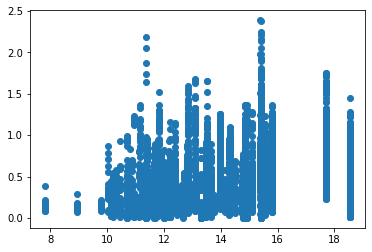

In [22]:
plt.scatter(np.log(df["floesize"]), df["freeboard"])

In [209]:
np.corrcoef(np.log(df["floesize"]), df["freeboard"])

array([[nan, nan],
       [nan,  1.]])

In [162]:
idx = img.index(df["x"], df["y"])
df["pix_x"] = idx[1]
df["pix_y"] = idx[0]

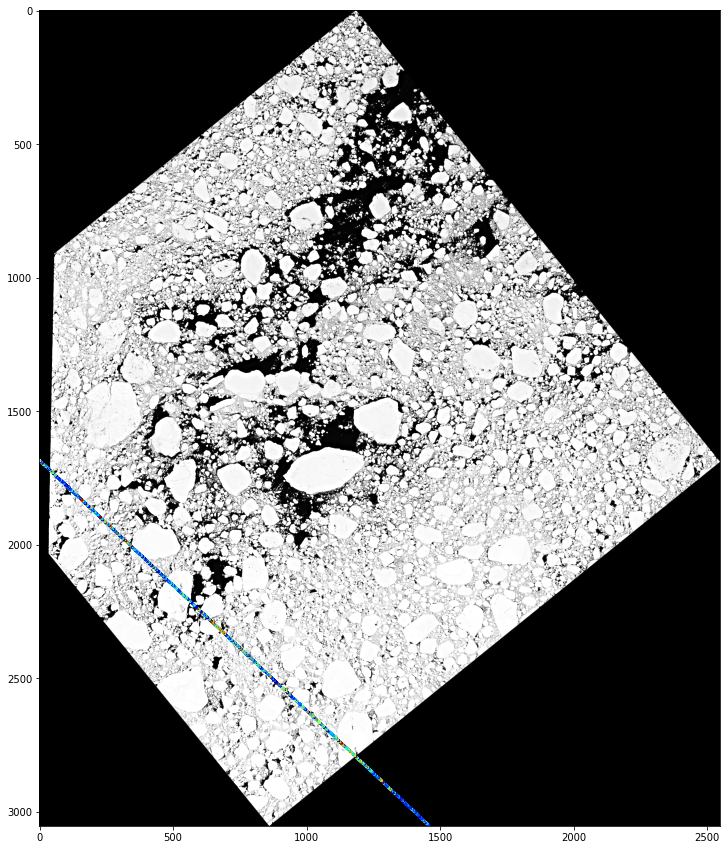

In [157]:
plt.figure(figsize = (15, 15))
plt.imshow(raw, vmin = 0, vmax = 10000, cmap ="gray")
plt.scatter(df["pix_x"], df["pix_y"], c = df["freeboard"], vmin = 0, vmax = 1, s=2, cmap = "jet")

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [The OpenAltimetry API](https://openaltimetry.org/data/swagger-ui/)
* [Google Earth Engine JavaScript and Python Guides](https://developers.google.com/earth-engine/guides)
* [The geemap package](https://geemap.org/) and [tutorials](https://geemap.org/tutorials/)